<a href="https://colab.research.google.com/github/Rishit02/project1/blob/main/rishit_khandelwal_Impl_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


In [56]:
# Load dataset
url = 'https://raw.githubusercontent.com/Rishit02/project1/main/NVDA%20(2).csv'
# Read and parse data
stock_data = pd.read_csv(url)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])
stock_data.index = stock_data['Date']
df = stock_data

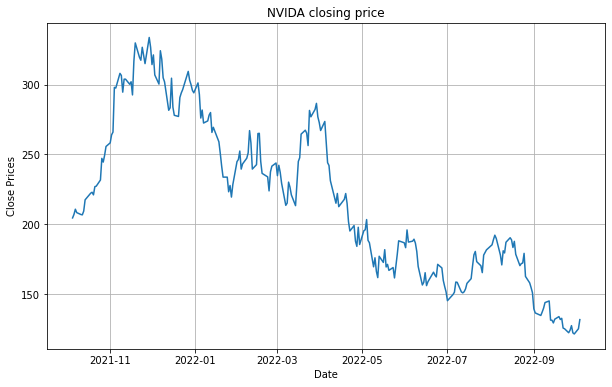

In [57]:
# visualize stock close price (optional)
df_close = stock_data['Close']
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('NVIDA closing price')
plt.show()

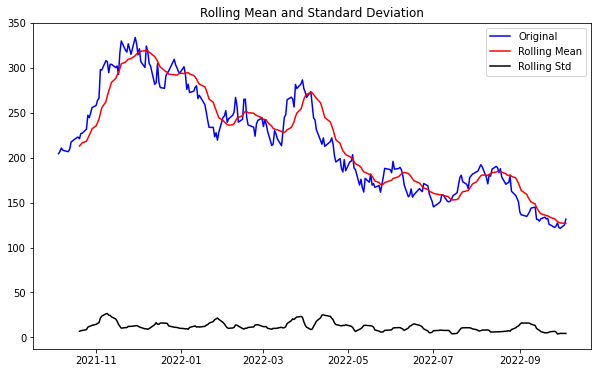

Results of dickey fuller test
Test Statistics                 -0.775832
p-value                          0.826118
No. of lags used                 0.000000
Number of observations used    251.000000
critical value (1%)             -3.456674
critical value (5%)             -2.873125
critical value (10%)            -2.572944
dtype: float64


In [58]:
# Test for staionarity
def test_stat(timeseries):
    # Determing rolling statistics
    rollmean = timeseries.rolling(12).mean()
    rollstd = timeseries.rolling(12).std()
    # Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rollmean, color='red', label='Rolling Mean')
    plt.plot(rollstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stat(df_close)

In [59]:
# Make series stationary
# To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
# result = seasonal_decompose(df_close, model='multiplicative', period = 30)
# fig = plt.figure()  
# fig = result.plot()  
# fig.set_size_inches(16, 9)

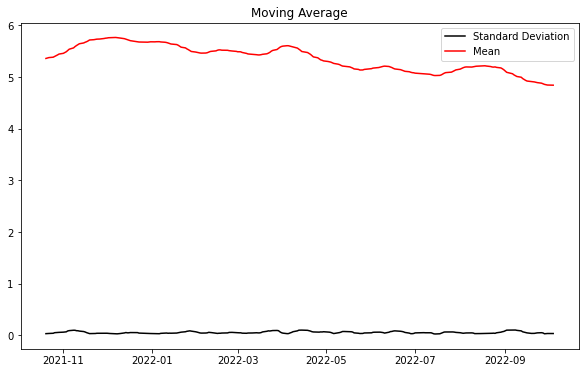

In [60]:
# if not stationary then eliminate trend
# Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

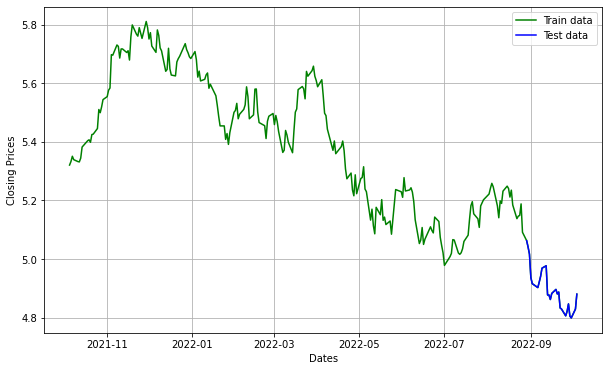

In [61]:
# split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [62]:
# We are choosing auto_arima so that we do not have to pick the p, d, q values oursleves
# Chooses p, d, q values with the least aic
model = pm.auto_arima(df['Close'], start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1821.468, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3446.149, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1823.022, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1822.899, Time=0.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2834.942, Time=0.28 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1823.136, Time=0.21 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1819.762, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2450.638, Time=0.14 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1818.155, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2748.307, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1819.798, Time=0.19 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1821.1

In [66]:
data = df['Close']
# Forecast
n_periods = 10
forecast, confint = model.predict(n_periods=n_periods, return_conf_int=True)
print(forecast)
forecast = pd.DataFrame(forecast, columns=['Close'])
forecast.to_csv('rishit_khandelwal_Impl_2.csv')

# index_of_fc = np.arange(len(data), len(data)+n_periods)

# make series for plotting purpose
# fc_series = pd.Series(fc, index=index_of_fc)
# lower_series = pd.Series(confint[:, 0], index=index_of_fc)
# upper_series = pd.Series(confint[:, 1], index=index_of_fc)
# # Plot
# plt.plot(data)
# plt.plot(fc_series, color='darkgreen')
# plt.fill_between(lower_series.index, 
#                  lower_series, 
#                  upper_series, 
#                  color='k', alpha=.15)

# plt.title("Final Forecast of WWW Usage")
# plt.show()

252    132.467446
253    133.255313
254    134.033713
255    134.802761
256    135.562568
257    136.313245
258    137.054903
259    137.787650
260    138.511593
261    139.226837
dtype: float64
